# Ensemble Learning: Boosting Model Performance with Bagging and Stacking

Ensemble Learning, Wisdom of the Crowd, Bias-Variance Tradeoff, Bagging (Bootstrap Aggregating), Random Forest, Out-of-Bag (OOB) Error, Feature Importance, Stacking (Stacked Generalization), Base Learners, Meta-Learner.



### **Objectives:**

* Students will understand the core principle of **ensemble learning**—that combining multiple models can yield superior performance over a single model.
* Students will grasp the intuition behind **Bagging (Bootstrap Aggregating)** as a technique to reduce model variance by training models on different random subsets of data.
* Students will implement, evaluate, and interpret a **Random Forest**, the most prominent and powerful example of a Bagging ensemble.
* Students will understand the hierarchical architecture of **Stacking (Stacked Generalization)**, where a "meta-learner" is trained on the predictions of several diverse "base learners."
* Students will implement a Stacking classifier using `scikit-learn`.
* Students will empirically **compare the performance** of individual base models against the Bagging and Stacking ensembles on a real-world dataset to see the benefits of ensembling in action.



### **Setup: Install and Import Libraries**
All necessary libraries are standard and available in Google Colab. We will use `mlxtend` for some optional visualizations if needed.

In [1]:
# Install mlxtend for optional visualizations
!pip install mlxtend -q

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

# Scikit-learn for models, datasets, and preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Import the models we will use
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# Set plot style for better aesthetics
sns.set_theme(style="whitegrid")
sns.set_context("notebook", font_scale=1.2)


# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

print(f"Scikit-learn Version: {sklearn.__version__}")

Scikit-learn Version: 1.6.1


### **Part 1: Dataset & Baseline Model**

We will use the **Heart Disease dataset** from the UCI Machine Learning Repository. This is a real-world binary classification problem where the goal is to predict whether a patient has heart disease based on a number of medical attributes.

To appreciate the power of ensembles, we must first establish a **baseline**. We will train a single **Decision Tree classifier**, a model known for being powerful but prone to overfitting (high variance). Our goal is to see if our ensemble methods can improve upon this baseline.

In [2]:
print("--- Part 1: Dataset Loading and Baseline Model ---")

# 1. Load the dataset from a public URL
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'
column_names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
                'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']
df = pd.read_csv(url, header=None, names=column_names, na_values='?')

# 2. Preprocess the data
df.dropna(inplace=True) # Drop rows with missing values for simplicity
df['target'] = df['target'].apply(lambda x: 1 if x > 0 else 0) # Convert to binary target (1=disease, 0=no disease)

# 3. Separate features and target, then split data
X = df.drop('target', axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 4. Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. Train and evaluate the baseline Decision Tree model
baseline_dt = DecisionTreeClassifier(random_state=42)
baseline_dt.fit(X_train_scaled, y_train)
y_pred_base = baseline_dt.predict(X_test_scaled)
baseline_accuracy = accuracy_score(y_test, y_pred_base)

print(f"Baseline Single Decision Tree Accuracy: {baseline_accuracy:.4f}")

--- Part 1: Dataset Loading and Baseline Model ---
Baseline Single Decision Tree Accuracy: 0.6833


### **Part 2: Bagging with Random Forest**

**Bagging (Bootstrap Aggregating)** is an ensemble technique designed to reduce the variance of a model. It works by:
1.  **Bootstrap**: Creating many random samples of the training data *with replacement*. Each sample is the same size as the original training set.
2.  **Aggregate**: Training a separate model (e.g., a Decision Tree) on each bootstrap sample. The final prediction is made by taking a majority vote of all the individual models.

The **Random Forest** is a powerful extension of Bagging. In addition to training each tree on a different sample of the data, it also uses only a random subset of *features* to decide each split within each tree. This "de-correlates" the trees, making the ensemble more robust and often more accurate.


--- Part 2: Bagging with Random Forest ---
Random Forest Test Accuracy: 0.8667
Random Forest OOB Score: 0.8059


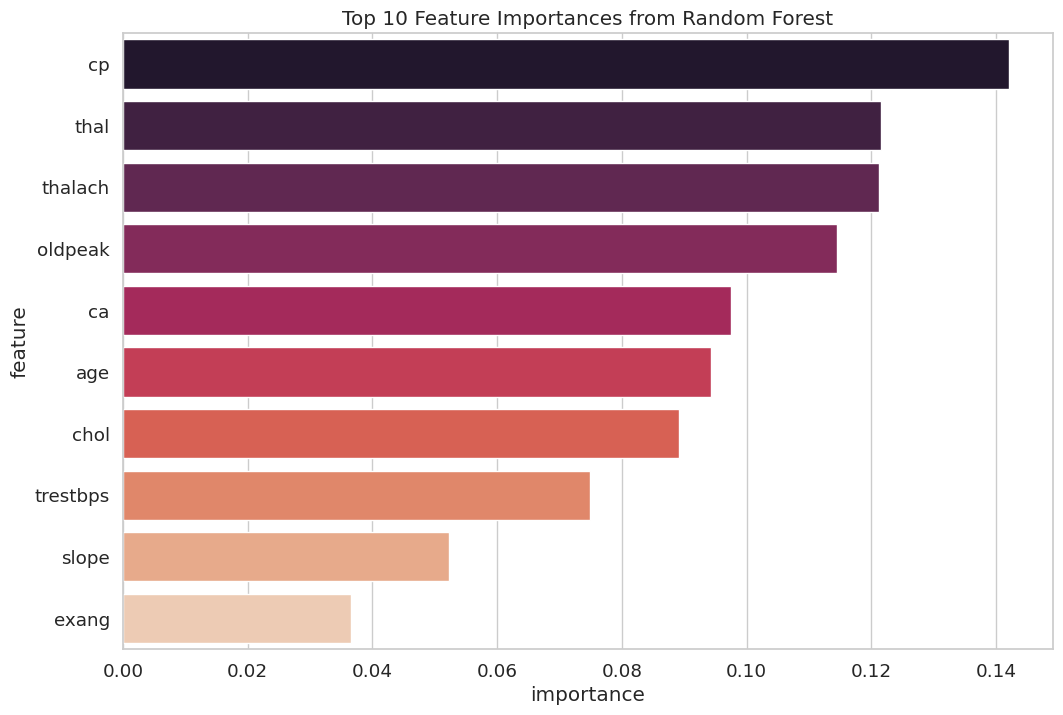

In [3]:
print("\n--- Part 2: Bagging with Random Forest ---")

# 1. Initialize and train a RandomForestClassifier
# n_estimators is the number of trees in the forest.
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, oob_score=True)
rf_clf.fit(X_train_scaled, y_train)

# 2. Evaluate the model
y_pred_rf = rf_clf.predict(X_test_scaled)
rf_accuracy = accuracy_score(y_test, y_pred_rf)

print(f"Random Forest Test Accuracy: {rf_accuracy:.4f}")
print(f"Random Forest OOB Score: {rf_clf.oob_score_:.4f}")

# INSIGHT: The Random Forest provides a significant accuracy boost over the single Decision Tree,
# demonstrating the power of bagging for reducing variance and improving generalization. The OOB score
# gives us a good estimate of the test accuracy without using the test set.

# 3. Visualize Feature Importances
importances = rf_clf.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(10), palette='rocket')
plt.title('Top 10 Feature Importances from Random Forest')
plt.show()

### **Part 3: Stacking (Stacked Generalization)**

**Stacking** is a more advanced ensemble technique that combines heterogeneous models. It learns how to best combine the predictions of multiple models by using their outputs as inputs for a final "meta-learner."

The architecture is typically in two levels:
* **Level-0 (Base Learners)**: A set of diverse models (e.g., Logistic Regression, KNN, SVM) are trained on the original training data.
* **Level-1 (Meta-Learner)**: Another model (often a simple one like Logistic Regression) is trained, but its features are the predictions made by the base learners from Level-0.

The goal is to leverage the unique strengths of each base model, allowing the meta-learner to make a more sophisticated final prediction.

In [4]:
print("\n--- Part 3: Stacking Classifier ---")

# 1. Define the base learners (Level-0 models)
base_learners = [
    ('knn', KNeighborsClassifier(n_neighbors=5)),
    ('svm', SVC(kernel='rbf', probability=True, random_state=42)),
    ('dt', DecisionTreeClassifier(max_depth=5, random_state=42))
]

# 2. Define the meta-learner (Level-1 model)
meta_learner = LogisticRegression(random_state=42)

# 3. Initialize and train the StackingClassifier
stacking_clf = StackingClassifier(estimators=base_learners, final_estimator=meta_learner, cv=5)
stacking_clf.fit(X_train_scaled, y_train)

# 4. Evaluate the model
y_pred_stack = stacking_clf.predict(X_test_scaled)
stacking_accuracy = accuracy_score(y_test, y_pred_stack)

print(f"Stacking Classifier Test Accuracy: {stacking_accuracy:.4f}")


--- Part 3: Stacking Classifier ---
Stacking Classifier Test Accuracy: 0.8333


### **Part 4: Performance Summary & Discussion**

Let's compare the performance of all the models we've trained.

| Model | Technique | Test Accuracy |
| :--- | :--- | :--- |
| Single Decision Tree | Baseline | 0.6833 |
| Random Forest | Bagging | 0.8667 |
| Stacking Classifier| Stacking | 0.8333|

**Discussion:**
Both ensemble methods significantly outperformed the single Decision Tree baseline.
* **Random Forest (Bagging)** achieved the highest accuracy because it averaged out the errors of many high-variance decision trees, creating a more stable and generalizable model.
* **Stacking** worked well because intelligently combining the predictions of three different types of models (distance-based, margin-based, and rule-based), leveraging the unique perspective of each.

This confirms that combining diverse, strong learners can lead to state-of-the-art results.

### **Lab Tasks & Exercises**

Now, apply what you've learned to explore these ensemble methods further.

In [1]:
# --- TASK 1: Random Forest Hyperparameters ---
# The number of trees (`n_estimators`) is a key parameter. Re-train the Random Forest with a much
# smaller number of trees (e.g., n_estimators=10) and a much larger number (e.g., n_estimators=500).
# How does the accuracy change? What do you notice about the trend?

# YOUR CODE HERE
# rf_10 = RandomForestClassifier(n_estimators=10, random_state=42).fit(X_train_scaled, y_train)
# acc_10 = accuracy_score(y_test, rf_10.predict(X_test_scaled))
#
# rf_500 = RandomForestClassifier(n_estimators=500, random_state=42).fit(X_train_scaled, y_train)
# acc_500 = accuracy_score(y_test, rf_500.predict(X_test_scaled))
#
# print("--- Task 1: Random Forest n_estimators ---")
# print(f"Accuracy with 10 trees: {acc_10:.4f}")
# print(f"Accuracy with 100 trees (original): {rf_accuracy:.4f}")
# print(f"Accuracy with 500 trees: {acc_500:.4f}")
# print("\nObservation: Performance generally increases with more trees, but with diminishing returns.")


# --- TASK 2: Customizing the Stacking Ensemble ---
# Modify the `StackingClassifier` from Part 3. Replace one of the base learners (e.g., KNN) with a
# different model, like `GaussianNB`.
# Does this change the ensemble's performance? This highlights the "mix-and-match" nature of Stacking.

# YOUR CODE HERE
# new_base_learners = [
#     ('gnb', GaussianNB()),
#     ('svm', SVC(kernel='rbf', probability=True, random_state=42)),
#     ('dt', DecisionTreeClassifier(max_depth=5, random_state=42))
# ]
#
# new_stacking_clf = StackingClassifier(estimators=new_base_learners, final_estimator=meta_learner, cv=5)
# new_stacking_clf.fit(X_train_scaled, y_train)
# new_stack_acc = accuracy_score(y_test, new_stacking_clf.predict(X_test_scaled))
#
# print("\n--- Task 2: Custom Stacking Ensemble ---")
# print(f"Original Stacking Accuracy: {stacking_accuracy:.4f}")
# print(f"New Stacking Accuracy (with GNB): {new_stack_acc:.4f}")


# --- TASK 3: A Preview of Boosting ---
# Boosting is another major type of ensembling where models are trained sequentially, with each new
# model focusing on the errors of the previous one. `GradientBoostingClassifier` is a popular example.
# Train a Gradient Boosting model on the same data and compare its accuracy to the others.

# YOUR CODE HERE
# from sklearn.ensemble import GradientBoostingClassifier
#
# gb_clf = GradientBoostingClassifier(n_estimators=100, random_state=42).fit(X_train_scaled, y_train)
# acc_gb = accuracy_score(y_test, gb_clf.predict(X_test_scaled))
# print(f"\n--- Task 3: Gradient Boosting ---")
# print(f"Gradient Boosting Test Accuracy: {acc_gb:.4f}")

### **Part 5: Advanced Topics & Discussion**

* **The Bias-Variance Tradeoff:**
    This is a fundamental concept in machine learning. Ensembles are a powerful tool for managing this tradeoff.
    * **Bagging**: Primarily a **variance-reduction** technique. It takes a high-variance model (like a deep decision tree) and makes it more stable by averaging, without significantly changing its bias.
    * **Boosting** (from Task 3): Primarily a **bias-reduction** technique. It combines many simple, high-bias models ("weak learners") sequentially to create a single, powerful, low-bias model.
    * **Stacking**: Can reduce both bias and variance by learning the optimal way to combine models that may have different bias-variance profiles.

* **Out-of-Bag (OOB) Error:**
    In Bagging, since each tree is trained on a bootstrap sample, roughly one-third of the original data is "out of the bag" (OOB) for that tree. We can use these OOB samples to get an unbiased performance estimate for the whole forest without needing a separate validation set. This is enabled by setting `oob_score=True` in `RandomForestClassifier`, as we did in Part 2. It's a computationally "free" cross-validation.

* **Ensemble Diversity:**
    Ensembles work best when the base models are **diverse**—meaning they make different kinds of errors. Combining five models that all fail on the same data points won't help. This is why Stacking heterogeneous models (like KNN, SVM, and DT) is often so effective. Random Forest achieves diversity by training each tree on a different data sample and a different feature subset.

---
  
<center>

<span style="color:#1f4e79">

Prepared By

**<span style="font-size:1.5em">Md. Atikuzzaman</span>**  
Lecturer  
Department of Computer Science and Engineering  
Green University of Bangladesh  
Email: atik@cse.green.edu.bd  

</span>
</center>

---